In [17]:
from scripts import NN
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
import random
import itertools
import pandas as pd
sns.set_context("talk")


## Part 1. Implement a feed-forward, neural network with standard sigmoidal units. Demonstrate its ability to correctly solve the 8 x 3 x 8 autoencoder task

The model produced using the parameters described below was able to be trained to roughly recreate the original input, demonstrating its ability to act as an autoencoder. I used all 8 combinations of 1-bit-on 8-bit vectors as the input and calculated loss using the same matrix as the expected output. As the graph shows, the loss decreases very quickly as the network is trained, indicating that the neural net is becoming better at recreating the input. The final loss (calculated as average binary cross-entropy loss per epoch) is about 0.6885, which is far below the original loss of >8.

The final AUC of \~1 also suggests that the output of the autoencoder produces values close to 1 where the input is 1 and 0 where the input is 0, and is good at separating out the different 8-bit vectors at any threshold. Looking at the data manually, values that are supposed to be 1 tend to be much higher (\~0.7-0.8) compared to values that are supposed to be 0 (\~0.0 - 0.1)



Predicted values:
[[0.82 0.   0.   0.04 0.   0.08 0.   0.15]
 [0.   0.78 0.   0.02 0.15 0.13 0.   0.  ]
 [0.   0.   0.59 0.05 0.02 0.   0.22 0.14]
 [0.   0.   0.   0.64 0.04 0.01 0.   0.02]
 [0.   0.08 0.   0.13 0.7  0.   0.16 0.  ]
 [0.05 0.04 0.   0.13 0.   0.82 0.   0.  ]
 [0.   0.   0.24 0.04 0.17 0.   0.54 0.01]
 [0.05 0.   0.1  0.16 0.   0.   0.   0.74]]


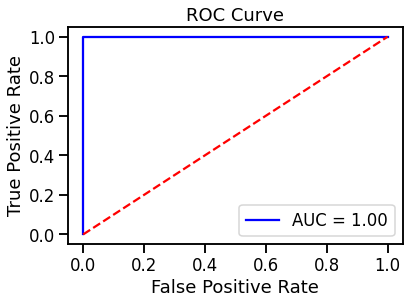

Final loss = 0.6885295102785269


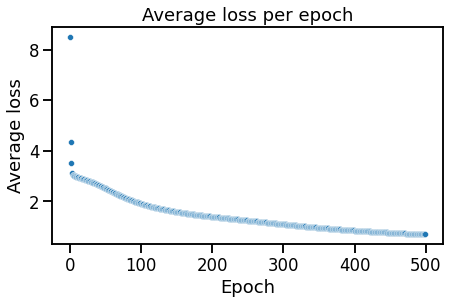

In [9]:
# set up an 8x3x8 autoencoder network, with sigmoid activation function
nn = NN.NeuralNetwork(sizes=[8, 3, 8], activation="sigmoid", alpha=1, epochs=500)

# show that it can solve an 8 x 3 x 8 autoencoder task 
y = np.array([[1,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0],
              [0,0,0,1,0,0,0,0],
              [0,0,0,0,1,0,0,0],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,1,0],
              [0,0,0,0,0,0,0,1]])

# input vector into autoencoder and fit (feedforward + backpropagation)
nn.fit(y, y) 

# Predict using the original output and print output layer
pred = nn.predict(y)
print("Predicted values:")
print(np.around(pred, decimals=2))

# Report specificity and sensitivity metrics plotted as an ROC curve
# An AUC of ~1.00 suggests that the autoencoder works as intended and is able to recapitulate input values.
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
roc = metrics.roc_curve(y.flatten(), pred.flatten(), pos_label=1)
roc_auc = metrics.roc_auc_score(y.flatten(), pred.flatten())

plt.title('ROC Curve')
plt.plot(roc[0], roc[1], 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Here is a graph of the average loss per epoch.
# The sharp drop in average loss indicates that the model is 
# being trained to create outputs that are closer to the input.
fix, ax = plt.subplots(figsize=(7,4))
sns.scatterplot(x=range(len(nn.losses)), y = nn.losses, s=35)
plt.title('Average loss per epoch')
plt.ylabel('Average loss')
plt.xlabel('Epoch')

# print the final loss
print("Final loss = " + str(nn.losses[-1]))



## Part 2: Adapt for classification, and develop training regime (10 points)

**2) Set up a procedure to encode DNA sequences (Rap1 binding sites) as input for your neural network. Describe your process of encoding your training DNA sequences into input vectors in detail. Include a description of how you think the representation might affect your network’s predictions. Consider how your encoding strategy may influence your network predictions.**

I used one-hot encoding to first turn the fasta sequence into a binary matrix of size n x f where n is the length of the sequence and f represented each of the four nucleotides. Each nucleotide of the sequence was encoded with the following mapping: 

A = [1,0,0,0]  
G = [0,1,0,0]  
C = [0,0,1,0]  
T = [0,0,0,1]  

I then flattened the one-hot encoded matrix to generate a vector of length 4 * n as the input into the neural network. Since the one-hot encoding and flattening generated a vector, it was easy to use directly as an input layer into the NN, especially for a batch approach where a matrix containing multiple vectors/encoded sequences can be directly used as the input.   

Additionally, because each nucleotide is only expressed using 1's and 0's, this does not bias the input, since there should be no numerical relationship between different nucleotides (eg. if A=1 and G=2, this can result in G being more "important" than A and having more influence on the training). 

One general disadvantage of one-hot encoding is the curse of dimensionality, since having too many features forces the input vector and number of input nodes to be very high. Since we are working with only 4 features (A, G, C, and T) and the input sequence will be kept to 17 nucleotides in length, this is not too big of a problem, but other approaches might be considered for other analysis that do require more features/input items.

The one-hot encoding function is a static method in the NN.py file. Below is a demonstration of it being able to encode the first 5 sequences from the the given fasta files. Additional unit tests also show that the encoding works.



In [10]:
fastas = NN.read_fasta("./data/rap1-lieb-positives.txt")

for f in fastas[:5]:
    print(f)
    print(NN.encode(f))
    

ACATCCGTGCACCTCCG
[1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0]
ACACCCAGACATCGGGC
[1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0]
CCACCCGTACCCATGAC
[0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0
 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0]
GCACCCATACATTACAT
[0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1]
ACATCCATACACCCTCT
[1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]


**3) Design a training regime that will use both positive and negative training data to train your predictive model. Note that if you use a naive scheme here, which overweights the negative data, your system will probably not converge (it will just call everything a non-Rap1 site).  How was your training regime designed so as to prevent the negative training data from overwhelming the positive training data?**

I downsampled the number of negative training data, in order to prevent the model from overfitting to all the negative training data. If I had used all the available training data, there would be many more negative examples compared to positive examples, which would bias the network to predict that sequences were more likely to be negative than positive.  

My downsampling considered both the number of negative training data, as well as the length of the negative training sequence, in order to match the positive sequences. I randomly sampled the negative training data to select 137 sequences, then randomly selected one 17-mer from each sequence to produce the downsampled negative data. I excluded negative sequences that contained a positive sequence, since these sequences would be incorrectly labeled when training.


In [11]:
# Set random seed to ensure random sampling is consistent
random.seed(0)

# Read in the fasta sequences
neg_dict = NN.read_fasta("./data/yeast-upstream-1k-negative.fa")
neg = list(neg_dict.keys())
pos = NN.read_fasta("./data/rap1-lieb-positives.txt")

# Remove any negative samples that contains a positive sequence
# so they are not considered during negative sample selection
for pos_f in pos:
    for ind in range(len(neg)):
        if pos_f in neg[ind]:
            neg[ind] = "pos" 

neg = [seq for seq in neg if "pos" not in seq]
      
# Randomly sample the negatives to balance the number of positive and negative samples
# A seed is set to ensure that the same samples are chosen each time
rand_neg = random.sample(neg, len(pos))

# Randomly sample 17-mers from each sequence to create downsampled negative samples
rand17_ind = [random.randint(0,len(seq)-17) for seq in rand_neg]
rand17_neg = [seq[ind:ind+17] for ind, seq in zip(rand17_ind, rand_neg)]
print("Number of sequences in downsampled set: %d"%len(rand17_neg))
print("Average length of sequences in downsampled set: %d"%(sum([len(i) for i in rand17_neg])/len(rand17_neg)))


Number of sequences in downsampled set: 137
Average length of sequences in downsampled set: 17


**4. Modify your implementation to take as input positive and negative examples of Rap1 binding sites (using your encoding from Q2) and produce an output probability between [0 - 1.0] indicating classification as a binding site (1.0) or not (0.0). Select a network architecture, and train your network using the training regime you described in Q3 on all the data.** 

**a. Provide an example of the input and output for one true positive sequence and one true negative sequence.**  
- The input for a positive sequence ("ACATCCGTGCACCTCCG") is printed below
- The input for a negative sequence ("CCCTGTTTACCGGAGAG") is printed below
- The output for the positive example was 0.98565412 and output for the negative example was 0.01192784, which makes sense because the positive output should be close to 1 (is a TF) and the negative output should be close to 0 (is not a TF)
- It's good to see that the positive example is being called as such, because this could be seen as an indication that the model was not overwhelmed by negative examples (due to downsampling). Of course, the model is being trained and tested on the same dataset so will need to be confirmed with cross-validation or other train/test split approaches 

**b. Describe your network architecture, and the results of your training. How did your network perform in terms of minimizing error?**  
I have an input layer of 68 nodes, 2 hidden layers with 50 and 25 nodes respectively, and an output layer of just a single node that is between 0 and 1 and corresponds to the probability of the input being a transcription factor. Training loss decreased significantly over epochs, with a loss of 0.0109 after 100 epochs. 
 
**c. What was your stop criterion for convergence in your learned parameters? How did you decide this?**
I stopped when the loss was less than 0.01 or when the specified number of epochs have been run. Having both these criteria would ensure that the network either converged to an acceptable loss or would be stopped and prevented from running in an infinite loop if the network did not converge to an acceptable degree. Here, the network was stopped by the max number of epochs, but also came close to the 0.01 threshold, indicating that this is a reasonable loss threshold. Because my implementation includes the threshold as an adjustable parameter, it can be tuned for specific neural nets if necessary. 


Positive encoded: [1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0]
Negative encoded: [0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0]

x_test dimensions: (274, 68)
y_test dimensions: (274, 1)

Positive output: ACATCCGTGCACCTCCG = [0.98565412]
Negative output: CCCTGTTTACCGGAGAG = [0.01192784]


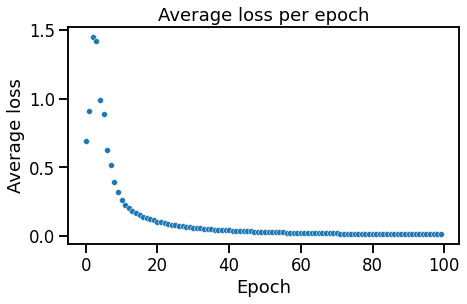

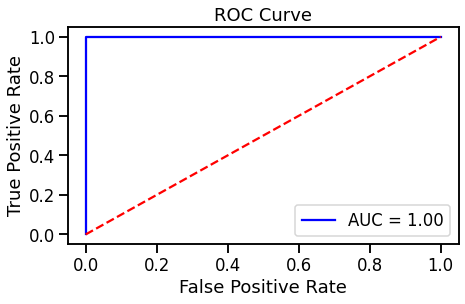


Final loss = 0.010925877113496685


In [14]:
# I used the positive and negative sequences read in / generated for Q3 
# where "pos" are the positive examples and "rand17_neg" are the negative examples

# Create empty list to store the test input / output
x_test = []
y_test = []

# Encode each true positive sequence and add it to x_test
# Add the correct label (1 for positive) for each sequence to y_test
for seq in pos:
    x_test.append(NN.encode(seq))
    y_test.append([1])
    
# Repeat for each true negative sequence
# Use 0 for the negative labels
for seq in rand17_neg:
    x_test.append(NN.encode(seq))
    y_test.append([0])
    
# Print the input for a positive and negative example
print("Positive encoded: " + str(x_test[0]))
print("Negative encoded: " + str(x_test[-1]))

# Convert lists to array for input into the neural net
x_test = np.array(x_test)
y_test = np.array(y_test)

# Check that the encoded sequences are the correct dimensions
# x_test should be 137 * 2 samples by 4*17 nucleotides/features -> 274 x 68 
# y_test should be a vector of length = 137 * 2 labels = 274 labels
print()
print("x_test dimensions: "+ str(x_test.shape))
print("y_test dimensions: "+ str(y_test.shape))

# create a neural net with an output layer of 1, with sigmoid activation function
nn = NN.NeuralNetwork(sizes=[68, 50, 25, 1], activation="sigmoid", alpha=1, epochs=100)

# input vector into neural net and train (feedforward + backpropagation)
nn.fit(x_test, y_test) 

# Here is a graph of the average loss per epoch.
# The sharp drop in average loss indicates that the model is being trained as expected.
fix, ax = plt.subplots(figsize=(7,4))
sns.scatterplot(x=range(len(nn.losses)), y = nn.losses, s=35)
plt.title('Average loss per epoch')
plt.ylabel('Average loss')
plt.xlabel('Epoch')

# Predict on the training dataset
pred = nn.predict(x_test)

# Print the first and last sequence and their outputs, which should be 
# close to 1 and 0, respectively
print()
print("Positive output: " + pos[0] + " = " + str(pred[0]))
print("Negative output: " + rand17_neg[-1] + " = " + str(pred[-1]))

# Compare the predictions to the ground truth and plot AUCROC curve
roc = metrics.roc_curve(y_test.flatten(), pred.flatten(), pos_label=1)
roc_auc = metrics.roc_auc_score(y_test.flatten(), pred.flatten())

fix, ax = plt.subplots(figsize=(7,4))
plt.title('ROC Curve')
plt.plot(roc[0], roc[1], 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Print the final loss
print()
print("Final loss = " + str(nn.losses[-1]))


## Part 3: Cross-validation (5 points)

**5) Evaluate your model’s classification performance via k-fold cross validation.**   

**a. How can you use k-fold cross validation to determine your model’s performance?**  
In k-fold cross validation, a labeled dataset is split into k (roughly) equal "folds". In each iteration, one fold is held out as a test set, while the other k-1 folds are used to train the dataset. The model is then tested on the hold-out fold and an AUC can be calculated using the labels of the held-out data. There are k total iterations, using each fold as the hold-out dataset once. 

By using k test sets, you can ensure that the model's performance is consistent no matter which random sample of training data is used. This also helps to ensure that your training set is well balanced - if the performance of the model is not consistent across folds, this could be an indication that your training set is skewed and that a random subset of the training set is not representative of the whole dataset. The value of k can affect this to some extent, as described in part b, but in general a good model should have a consistent AUC across training and test subsets.

Model performance can be calculated as an average AUC value across folds, as described further in part C. 

**b. Given the size of your dataset, positive and negative examples, how would you select a value for k?** 
Since the k determines the size of each fold/test set being tested each iteration, the k should be small enough so that each fold is large enough to validate the model. For example, since the training data used here (positive + negative examples) has a size of 274, it would not make sense to have a k of 20, since that would leave only ~13 samples in the test sets, which is too small to be representative of how well the model is performing. Additionally, having too many folds (large k) means that you need to do many iterations to test on every fold, and can be very slow to run.  

On the lower end, k must be greater than 1 and should ideally be 3 or more so that there are at least 3 test sets being evaluated. Typically, the k is 5 or 10, and as demonstrated below, the value of k is not necessarily important in evaluating the model as long as it is a reasonable size. I selected a value of k=7 for this part and part 4, mostly arbitrarily but it seemed like a good middle ground.

**c. Using the selected value of k, determine a relevant metric of performance for each fold. Describe how your model performed under cross validation.**  
AUC is a proxy to measure the specificity and sensitivity of a model, and can be adapted for k-fold validation to determine the performance of the model for each fold. An AUC can be calculated for each hold-out dataset and an average AUC can be calculated across the folds to test for which value of k is most reasonable. 

The average AUC, as shown below for the model with architecture=[68, 50, 25, 1], activation=sigmoid, alpha=1, epochs=100, is 1 across all values of k tested, including k=7. This means that the model is very good at differentiating transcription factors and predicts all items in each fold/test-set correctly. 

Loss can also be used as a metric of how "good" the model is, and might be better to differentiate models in this case where all the AUCs are 1, but the loss only takes the training set into account, not the test set, so is only a good validation of training and not the predictive power of the model. 




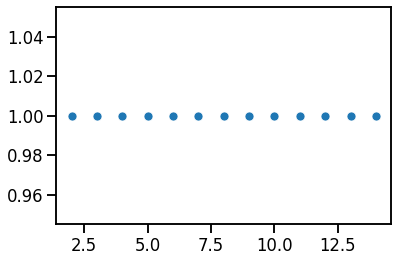

In [16]:
# Use the training set produced from Q4 in the previous cells 
# where x_test are the input samples and y_test are the corresponding labels

# store the auc 
k_auc = []

# perform k-fold cross validation using various k
for k in range(2,15):
    
    # Reset the parameters of the model (using seed=0)
    # This is necessary otherwise the weights and bias would change every time I ran kfold()
    params = {"seed":0, "sizes":[68, 50, 25, 1], "activation":"sigmoid", "alpha":1, "epochs":100}
    
    # Cross fold validation
    auc = NN.kfold(k, x_test, y_test, **params)
    k_auc.append(auc)

# plot average AUCs for each value of k
fig, ax = plt.subplots(figsize=(6,4))
ax=sns.scatterplot(x=range(2,15), y=k_auc)



## Part 4: Extension (required but graded generously) (5 points)

I implemented a genetic algorithm for hyperparameter searching. A genetic algorithm takes a population of "parent" models and iteratively selects the best hybrid models generated from this parent population. The hybrid models are then used as a new set of parent models, resulting in (ideally) better models in each generation. 

The parent models can be generated randomly, or sampled from a set of expected hyperparameters. I chose to define the set of hyperparamenters that the models could have to limit the search space of the algorithm. I varied the architecture, learning rate, and number of epochs in each model, and the parent population consisted of all combinations of the following:

- layers = [[68,50,1], [68,25,1], [68, 60,30,1], [68,45,15,1]]
- learning rate = [0.05, 0.1, 0.5, 1, 2]
- epochs = [50,100, 150, 500]

The activation function used was the sigmoid function. I did not anticipate having problems with vanishing gradients, which can occur with sigmoid functions applied to deep networks, because I only tried models with 1-2 hidden layers. If I were using networks with more hidden layers, I would have tried using a ReLU activation function.  

To generate each subsequent population, genetic algorithms either use tournament or roulette selection. In roulette selection, each model has a specified chance of being chosen. For my implementation, I used tournament selection, which involves generating new hybrid models from the original models, then replacing original models with the best of the ones generated. For my implementation, I randomly select 4 parents, and apply a mutation rate (10%) to the alpha and epoch parameters of these models. I then generate 2 children from these parents, with a crossover rate of 50% and tested the models by k-fold cross validation. The model with the best average AUC was added to a list of children, until the number of children was equal to the number of parents, and then the children replaced the parents. This was repeated for a specified number of iterations, and the final best model was selected as the one with the most optimal parameters.

I realized too late that this is not the order that the video does this but this still seems to work and contains all the steps of an evolutionary/genetic algorithm.

Tl;dr this is my implementation:
- Generate a set of hyperparameters to test (parent population)
- For the number of iterations specified:
- Randomly select 4 models (apply mutation rate of 10%)
- Create children from the 4 models with a crossover rate of 50%
- Test the children by k-fold validation
- Add the child with the best average AUC to a list of children
- When the number of children = number of parent population, replace the parents

And this is what it was supposed to be:
- Generate a set of hyperparameters to test (parent population)
- For the number of iterations specified:
- Randomly select 4 models
- **Test the models by k-fold validation (roughly switched with next step in my implementation)** 
- Create children from the 2 best models with a crossover rate of 50%
- Apply mutation rate of 10% to children 
- Add the 2 children to a list of children
- When the number of children = number of parent population, replace the parents


The k-fold cross validation used was with a k=7, as described in part 3. The final best model selected was with parameters [layers =[68, 60, 30, 1], activaiton='sigmoid', alpha=1, epochs=500]. This model was used for the final test prediction.


In [15]:
# Generate a set of parameters to build models with
# so that I don't have the search the entire search space
params = []

layers = [[68,50,1], [68,25,1], [68, 60,30,1], [68,45,15,1]]
activation = ["sigmoid"]
lrs = [0.05, 0.1, 0.5, 1, 2]
epochs = [50,100, 150, 500]

params = list(itertools.product(*[layers, activation, lrs, epochs]))

# Use genetic algorithm to select the best model
NN.geneticAlgo(params, x_test, y_test, model=NN.NeuralNetwork, k=7, max_iter=5)


[[68, 60, 30, 1], 'sigmoid', 1, 500]
[[68, 60, 30, 1], 'sigmoid', 1, 500]
[[68, 60, 30, 1], 'sigmoid', 1, 500]
[[68, 60, 30, 1], 'sigmoid', 1, 500]
[[68, 60, 30, 1], 'sigmoid', 1, 500]


[[68, 60, 30, 1], 'sigmoid', 1, 500]

## Part 5: Evaluate your network on the final set.

**6) To provide an objective measure of your neural network's ability to classify binding sites, a test dataset has been provided (rap1-lieb-test.txt). There are no class labels on these sequences. Your goal is to maximize the separation in scores for the true Rap1 binding sites as compared with the non-sites**

Using the hyperparameters and architecture chosen in part 4 (layers=[68, 60, 30, 1], activation='sigmoid', learning rate=2, epochs=500), I trained the final model on the data set generated from part 2 and generated predictions for the test dataset. The prediction outputs are in tsv format in the file "./output/predictions.tsv"


In [14]:
# create a neural net with the architecture that was selected by the genetic algorithm
nn = NN.NeuralNetwork(sizes=[68, 60, 30, 1], activation="sigmoid", alpha=1, epochs=500)

# train the model on the full set of training data generated from Q2
nn.fit(x_test, y_test) 

# read in the test set
part5_seqs = NN.read_fasta("./data/rap1-lieb-test.txt")
part5_test = np.array([NN.encode(seq) for seq in part5_seqs])

# use the model for predictions of the test set
pred = nn.predict(part5_test) 

# print out the final predictions
pred_df = pd.DataFrame.from_dict(dict(zip(part5_seqs, pred)), orient="index")
pred_df.to_csv("./output/predictions.tsv", sep="\t", header=False)
    
